In [2]:
import numpy as np
import pandas as pd
import os
import glob
from shapely.geometry import Point, shape, mapping
import fiona
import rtree
import math
import json
import geopandas as gp
from geopandas.tools import sjoin
import matplotlib.pyplot as plt

In [3]:
path = '/Users/charlie/Desktop/Taipower/data/'

In [14]:
# filter out the lighting data which happen between 2014 and 2017
# below I take 2017 as example
all_files = glob.glob(os.path.join(path+'lighting/','*.txt'))
lighting_2017 = pd.read_csv(all_files[42],encoding='big5')
lighting_2017 = lighting_2017.rename(columns = {u'日期時間':'lt_date',u'奈秒':'nano_secs',u'經度':'lat',u'緯度':'lon',
                   u'電流強度(kA)':'lt_kA',u'雷擊型態':'lt_type'})
lighting_2017.lt_date = pd.to_datetime(lighting_2017.lt_date)

# filter lighting within typhoon alert period
# below I take NESATANDHAITANG in 2017 as example
lighting_2017 = lighting_2017.loc[(lighting_2017.lt_date > pd.to_datetime('2017-07-28 08:30:00'))&(lighting_2017.lt_date < pd.to_datetime('2017-07-31 08:30:00')),:]
lighting_2017 = lighting_2017.reset_index(drop=True)
lighting_2017['lt_latlon'] = lighting_2017[['lat','lon']].apply(tuple,axis=1)

In [67]:
# import the finished lighting data by year
lighting_2014 = pd.read_csv(path+'lighting_2014.csv',encoding='big5')

In [70]:
# transform it into geo form
geometry = [Point(xy) for xy in zip(lighting_2014[u'緯度'], lighting_2014[u'經度'])]
crs = {'init' :'epsg:4326','proj':'longlat'}
lt_2014 = gp.GeoDataFrame(lighting_2014, crs=crs, geometry=geometry)

In [4]:
# import polygon data for mapping
def read_shapefile(shp_path):
	"""
	Read a shapefile into a Pandas dataframe with a 'coords' column holding
	the geometry information. This uses the pyshp package
	"""
	import shapefile

	#read file, parse out the records and shapes
	sf = shapefile.Reader(shp_path)
	fields = [x[0] for x in sf.fields][1:]
	records = sf.records()
	shps = [s.points for s in sf.shapes()]

	#write into a dataframe
	df = pd.DataFrame(columns=fields, data=records)
	df = df.assign(coords=shps)

	return df

vil_latlon = read_shapefile(path + "village_latlon/VILLAGE_MOI_1060831.shp")
vil_latlon.loc[0,['VILLCODE','VILLNAME']] = ['10013030023','大鵬里']
vil_latlon = vil_latlon.loc[vil_latlon.VILLNAME !='',:]
print 'the number of polygons:{}'.format(len(vil_latlon))

FRC1  = gp.read_file('/Users/charlie/Desktop/Taipower/data/VILLAGE_MOI_1060831.shp')
key = list(set(vil_latlon.index))
FRC1 = FRC1.loc[FRC1.index.isin(key),:]

the number of polygons:7852


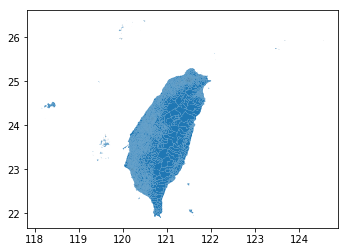

In [11]:
ax = FRC1.plot()
ax.figure

In [71]:
pointInPolys = sjoin(lt_2014, FRC1, how='left',op="within")
lighting_2014v2 = pointInPolys.dropna()
print 'the number of lighting within polygon:{}'.format(len(lighting_2014v2))
#lighting_2014v2.to_csv(path +'lighting_2014v2.csv',encoding='big5')

In [85]:
vil_latlon['index_right'] = vil_latlon.index
vil_latlon = vil_latlon.reset_index(drop=True)
vil_latlon.VILLCODE = vil_latlon.VILLCODE.astype(str)

7852


In [86]:
#將訓練資料與地區對應的測站合併
for i in range(0,len(vil_latlon)):
    if vil_latlon.loc[i,'VILLCODE'][3:5] =='00':
        vil_latlon.loc[i,'VilCode'] = vil_latlon.loc[i,'VILLCODE'][0:3] +  vil_latlon.loc[i,'VILLCODE'][5:7] + '00-'+  vil_latlon.loc[i,'VILLCODE'][8:11]
    else:
        vil_latlon.loc[i,'VilCode'] = vil_latlon.loc[i,'VILLCODE'][0:7] +  '-'+  vil_latlon.loc[i,'VILLCODE'][8:11]

,VILLCODE,COUNTYNAME,TOWNNAME,VILLNAME,VILLENG,COUNTYID,COUNTYCODE,TOWNID,TOWNCODE,NOTE,coords,index_right,VilCode
0,10013030023,屏東縣,東港鎮,大鵬里,,T,10013,T03,10013030,未編定村里,"[(120.48059195, 22.426862149), (120.476405146,...",0,1001303-023
1,64000130006,高雄市,林園區,中門里,Zhongmen Vil.,E,64000,E13,64000130,,"[(120.367720689, 22.495644521), (120.364268696...",1,6401300-006
2,10018010054,新竹市,東區,關新里,Guanxin Vil.,O,10018,O01,10018010,,"[(121.021652789, 24.785721177), (121.021643038...",2,1001801-054
3,10018020045,新竹市,北區,中雅里,Zhongya Vil.,O,10018,O02,10018020,,"[(120.955541047, 24.804825973), (120.955692224...",3,1001802-045
4,64000130008,高雄市,林園區,港埔里,Gangpu Vil.,E,64000,E13,64000130,,"[(120.373251337, 22.491231864), (120.371470967...",4,6401300-008


In [87]:
vil_latlon = vil_latlon.iloc[:,[1,2,3,11,12]]

,COUNTYNAME,TOWNNAME,VILLNAME,index_right,VilCode
0,屏東縣,東港鎮,大鵬里,0,1001303-023


In [88]:
lighting_2014v2 = pd.read_csv(path+'lighting_2014v2.csv',encoding='big5')
lighting_2015v2 = pd.read_csv(path+'lighting_2015v2.csv',encoding='big5')
lighting_2016v2 = pd.read_csv(path+'lighting_2016v2.csv',encoding='big5')
lighting_2017v2 = pd.read_csv(path+'lighting_2017v2.csv',encoding='big5')

In [89]:
lighting_2014v2 = lighting_2014v2.rename(columns={u'經度':'lat',u'緯度':'lon',u'奈秒':'nano_secs',u'電流強度(kA)':'lt_kA',u'雷擊型態':'lt_type'})
lighting_2015v2 = lighting_2015v2.rename(columns={u'經度':'lat',u'緯度':'lon',u'奈秒':'nano_secs',u'電流強度(kA)':'lt_kA',u'雷擊型態':'lt_type'})
lighting_2016v2 = lighting_2016v2.rename(columns={u'經度':'lat',u'緯度':'lon',u'奈秒':'nano_secs',u'電流強度(kA)':'lt_kA',u'雷擊型態':'lt_type'})

In [90]:
lt1 = pd.merge(lighting_2014v2, vil_latlon, how='left', on='index_right')
lt2 = pd.merge(lighting_2015v2, vil_latlon, how='left', on='index_right')
lt3 = pd.merge(lighting_2016v2, vil_latlon, how='left', on='index_right')
lt4 = pd.merge(lighting_2017v2, vil_latlon, how='left', on='index_right')
lighting = pd.concat([lt1,lt2,lt3,lt4],axis=0)

In [94]:
lighting = lighting.iloc[:,[6,0,1,4,11,12,13,14,15]]
#lighting.to_csv(path+'lighting.csv',encoding='utf-8')

In [97]:
lighting.lt_date = pd.to_datetime(lighting.lt_date)
lighting['day'] = lighting.lt_date.dt.day
lighting['hour'] = lighting.lt_date.dt.hour
lighting.loc[lighting.lt_kA =='-','lt_kA'] = 0

In [98]:
# assign typhoon names to lightings
#2014
lighting.loc[(lighting.iloc[:,4] >pd.to_datetime('2014-06-14 23:30'))&(lighting.iloc[:,4] <pd.to_datetime('2014-06-15 17:30')),'typhoon'] = 'HAGIBIS'
lighting.loc[(lighting.iloc[:,4] >pd.to_datetime('2014-09-19 08:30'))&(lighting.iloc[:,4] <pd.to_datetime('2014-09-22 08:30')),'typhoon'] = 'FUNG-WONG'
lighting.loc[(lighting.iloc[:,4] >pd.to_datetime('2014-07-21 17:30'))&(lighting.iloc[:,4] <pd.to_datetime('2014-07-23 23:30')),'typhoon'] = 'MATMO'
#2015
lighting.loc[(lighting.iloc[:,4] >pd.to_datetime('2015-07-09 05:30'))&(lighting.iloc[:,4] <pd.to_datetime('2015-07-11 11:30')),'typhoon'] = 'CHAN-HOM'
lighting.loc[(lighting.iloc[:,4] >pd.to_datetime('2015-08-06 11:30'))&(lighting.iloc[:,4] <pd.to_datetime('2015-08-09 08:30')),'typhoon'] = 'SOUDELOR'
lighting.loc[(lighting.iloc[:,4] >pd.to_datetime('2015-09-27'))&(lighting.iloc[:,4] <pd.to_datetime('2015-09-29')),'typhoon'] = 'DUJUAN'
#2016
lighting.loc[(lighting.iloc[:,4] >pd.to_datetime('2016-09-25 23:30'))&(lighting.iloc[:,4] <pd.to_datetime('2016-09-28 17:30')),'typhoon'] = 'MEGI'
lighting.loc[(lighting.iloc[:,4] >pd.to_datetime('2016-09-12 23:30'))&(lighting.iloc[:,4] <pd.to_datetime('2016-09-18 08:30')),'typhoon'] = 'MERANTIANDMALAKAS'
lighting.loc[(lighting.iloc[:,4] >pd.to_datetime('2016-07-06 14:30'))&(lighting.iloc[:,4] <pd.to_datetime('2016-07-09 14:30')),'typhoon'] = 'NEPARTAK'
#2017
lighting.loc[(lighting.lt_date > pd.to_datetime('2017-07-28 08:30:00'))&(lighting.lt_date < pd.to_datetime('2017-07-31 08:30:00')),'typhoon'] = 'NESATANDHAITANG'


In [101]:
lighting = lighting[lighting.typhoon.notnull()]

In [108]:
lighting.lt_kA = lighting.lt_kA.astype(float)
lighting['abs_lt_kA'] = np.abs(lighting.lt_kA)
#lighting.to_csv(path+'lighting.csv',encoding='utf-8')

In [111]:
lighting.head()

,VilCode,COUNTYNAME,TOWNNAME,VILLNAME,lt_date,lt_kA,lt_latlon,lt_type,nano_secs,typhoon,day,hour,abs_lt_kA
251,1001324-008,屏東縣,滿州鄉,港仔村,2014-06-14 23:30:27,0.0,"(22.145, 120.8562)",IC,208300000,HAGIBIS,14,23,0.0
252,1001503-005,花蓮縣,玉里鎮,國武里,2014-06-14 23:34:54,0.0,"(23.3338, 121.3237)",IC,352000000,HAGIBIS,14,23,0.0
253,1001416-004,臺東縣,蘭嶼鄉,椰油村,2014-06-14 23:37:27,0.0,"(22.0615, 121.5294)",IC,539300000,HAGIBIS,14,23,0.0
254,1001333-005,屏東縣,牡丹鄉,高士村,2014-06-14 23:37:43,0.0,"(22.1443, 120.8766)",IC,595400000,HAGIBIS,14,23,0.0
255,1001416-002,臺東縣,蘭嶼鄉,朗島村,2014-06-14 23:38:47,0.0,"(22.0819, 121.5046)",IC,523800000,HAGIBIS,14,23,0.0


In [148]:
#累積落雷次數
# the number of lighting 
accu_lt_num = lighting.groupby(['VilCode','typhoon'], as_index=False).agg({'lt_type':'count'})
accu_lt_num.columns.values[2] = 'accu_lt_num'

#小時平均落雷次數
# the mean number of lighting by hour
mean_hour_lt_num = lighting.groupby(['VilCode','typhoon','day','hour'], as_index=False).agg({'lt_type':'count'}).groupby(['VilCode','typhoon'], as_index=False).agg({'lt_type':'mean'})
mean_hour_lt_num.columns.values[2] = 'mean_hour_lt_num'

#日平均落雷次數
# the mean number of lighting by day
mean_day_lt_num = lighting.groupby(['VilCode','typhoon','day'], as_index=False).agg({'lt_type':'count'}).groupby(['VilCode','typhoon'], as_index=False).agg({'lt_type':'mean'})
mean_day_lt_num.columns.values[2] = 'mean_day_lt_num'

#小時最大落雷次數
# the max number of lighting by hour
max_hour_lt_num = lighting.groupby(['VilCode','typhoon','day','hour'], as_index=False).agg({'lt_type':'count'}).groupby(['VilCode','typhoon'], as_index=False).agg({'lt_type':'max'})
max_hour_lt_num.columns.values[2] = 'max_hour_lt_num'

#日最大落雷次數
# the max number of lighting by day
max_day_lt_num = lighting.groupby(['VilCode','typhoon','day'], as_index=False).agg({'lt_type':'count'}).groupby(['VilCode','typhoon'], as_index=False).agg({'lt_type':'max'})
max_day_lt_num.columns.values[2] = 'max_day_lt_num'

#最大電流強度
# the max lighting power(kA) 
max_lt = lighting.groupby(['VilCode','typhoon','day'], as_index=False).agg({'abs_lt_kA':'max'}).groupby(['VilCode','typhoon'], as_index=False).agg({'abs_lt_kA':'max'})
max_lt.columns.values[2] = 'abs_max_lt'

In [149]:
df = pd.read_csv(path +'df.csv')

In [153]:
df2 = pd.merge(df,accu_lt_num,how='left',on=['VilCode','typhoon'])
df2 = pd.merge(df2,mean_hour_lt_num,how='left',on=['VilCode','typhoon'])
df2 = pd.merge(df2,mean_day_lt_num,how='left',on=['VilCode','typhoon'])
df2 = pd.merge(df2,max_hour_lt_num,how='left',on=['VilCode','typhoon'])
df2 = pd.merge(df2,max_day_lt_num,how='left',on=['VilCode','typhoon'])
df2 = pd.merge(df2,max_lt,how='left',on=['VilCode','typhoon'])

In [156]:
df2[['accu_lt_num','mean_hour_lt_num', 'mean_day_lt_num', 'max_hour_lt_num',
       'max_day_lt_num','abs_max_lt']] = df2[['accu_lt_num','mean_hour_lt_num', 'mean_day_lt_num', 'max_hour_lt_num',
       'max_day_lt_num','abs_max_lt']].fillna(0)

In [157]:
#df_1114 = df_1114.iloc[:,3:]

In [158]:
df2.to_csv(path+'df.csv',index=False)